In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
df = pd.read_csv('AppleHistoricalData.csv')
df

,Date,Close/Last,Volume,Open,High,Low
0,03/01/2024,$179.66,73563080,$179.55,$180.53,$177.38
1,02/29/2024,$180.75,136682600,$181.27,$182.57,$179.53
2,02/28/2024,$181.42,48953940,$182.51,$183.12,$180.13
3,02/27/2024,$182.63,54318850,$181.10,$183.9225,$179.56
4,02/26/2024,$181.16,40867420,$182.24,$182.76,$180.65
...,...,...,...,...,...,...
119,09/11/2023,$179.36,58953050,$180.07,$180.30,$177.34
120,09/08/2023,$178.18,65602070,$178.35,$180.239,$177.79
121,09/07/2023,$177.56,112488800,$175.18,$178.21,$173.54
122,09/06/2023,$182.91,81755820,$188.40,$188.85,$181.47


In [3]:
df = df.rename(columns={'Close/Last': 'Close'})
df['Close'] = df['Close'].str.slice(1).astype(float)
df.Open = df.Open.str.slice(1).astype(float)
df.High = df.High.str.slice(1).astype(float)
df.Low = df.Low.str.slice(1).astype(float)
df.Volume.astype(float)
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
df

,Close,Volume,Open,High,Low,LogReturn
Date,,,,,,
2024-03-01,179.66,73563080,179.55,180.5300,177.38,NaN
2024-02-29,180.75,136682600,181.27,182.5700,179.53,0.006049
2024-02-28,181.42,48953940,182.51,183.1200,180.13,0.003700
2024-02-27,182.63,54318850,181.10,183.9225,179.56,0.006647
2024-02-26,181.16,40867420,182.24,182.7600,180.65,-0.008082
...,...,...,...,...,...,...
2023-09-11,179.36,58953050,180.07,180.3000,177.34,0.017208
2023-09-08,178.18,65602070,178.35,180.2390,177.79,-0.006601
2023-09-07,177.56,112488800,175.18,178.2100,173.54,-0.003486


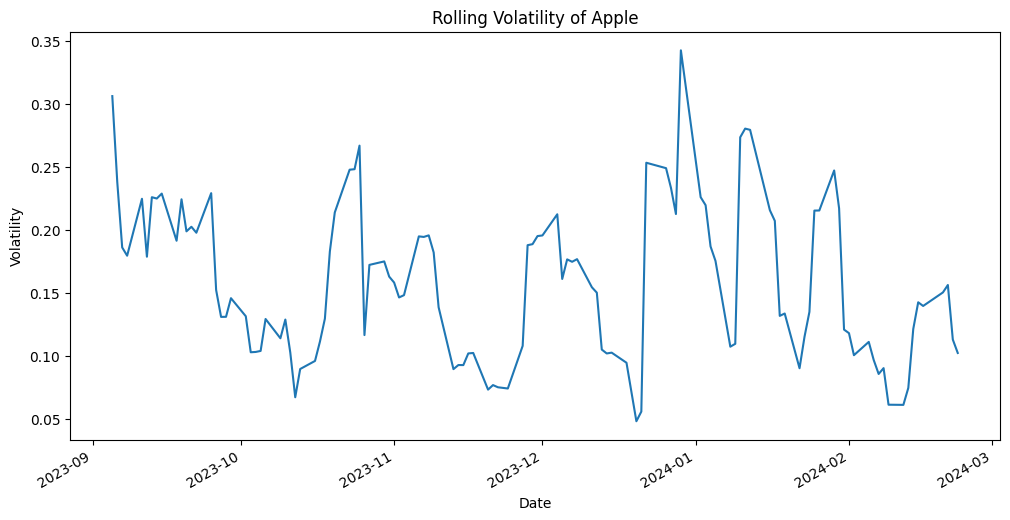

In [4]:
rolling_window = 5

# Calculate rolling volatility
df['RollingVol'] = df['LogReturn'].rolling(window=rolling_window).std() * np.sqrt(252)

# Plot rolling volatility
plt.figure(figsize=(12, 6))
df['RollingVol'].plot(title='Rolling Volatility of Apple')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()


In [5]:
df.head(10)

,Close,Volume,Open,High,Low,LogReturn,RollingVol
Date,,,,,,,
2024-03-01,179.66,73563080,179.55,180.5300,177.380,NaN,NaN
2024-02-29,180.75,136682600,181.27,182.5700,179.530,0.006049,NaN
2024-02-28,181.42,48953940,182.51,183.1200,180.130,0.003700,NaN
2024-02-27,182.63,54318850,181.10,183.9225,179.560,0.006647,NaN
2024-02-26,181.16,40867420,182.24,182.7600,180.650,-0.008082,NaN
2024-02-23,182.52,45119680,185.01,185.0400,182.230,0.007479,0.102211
2024-02-22,184.37,52292210,183.48,184.9550,182.460,0.010085,0.112862
2024-02-21,182.32,41529670,181.94,182.8888,180.660,-0.011181,0.156198
2024-02-20,181.56,53665550,181.79,182.4300,180.000,-0.004177,0.150288


In [6]:
from arch import arch_model
# Fit the GARCH model
model = arch_model(df.LogReturn.dropna(), vol='Garch', p=1, q=1)  # GARCH(1,1)
results = model.fit(update_freq=5)
df['Conditional Volatility'] = results.conditional_volatility * np.sqrt(252)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -375.54167811670237
            Iterations: 2
            Function evaluations: 24
            Gradient evaluations: 2


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001328. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


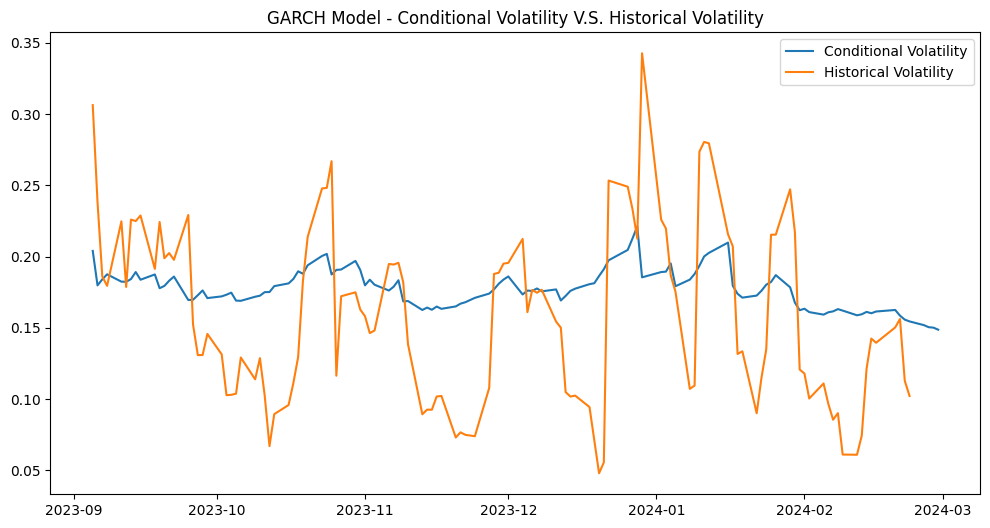

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(results.conditional_volatility* np.sqrt(252), label='Conditional Volatility')
plt.plot(df.RollingVol, label='Historical Volatility')
plt.title('GARCH Model - Conditional Volatility V.S. Historical Volatility')
plt.legend(loc='upper right')
plt.show()


In [76]:
forecast_horizon = df.index[0] - df.index[-1]
forecast_horizon = 178 #the same as calculated above
forecast = results.forecast(horizon=forecast_horizon)
forecast_variance = forecast.variance.dropna()
forecast_volatility = np.sqrt(forecast_variance)
forecast_volatility *= np.sqrt(252)

In [77]:
start_date = '2024-03-02'
forecast_dates = pd.date_range(start=start_date, periods=forecast_volatility.shape[1], freq='D')
forecast_df = pd.DataFrame(forecast_volatility.iloc[-1].values, index=forecast_dates, columns=['Forecasted Volatility'])
forecast_df.reset_index(inplace=True)
forecast_df.rename(columns={'index': 'Date'}, inplace=True)
forecast_df["Date"] = pd.to_datetime(forecast_df["Date"])

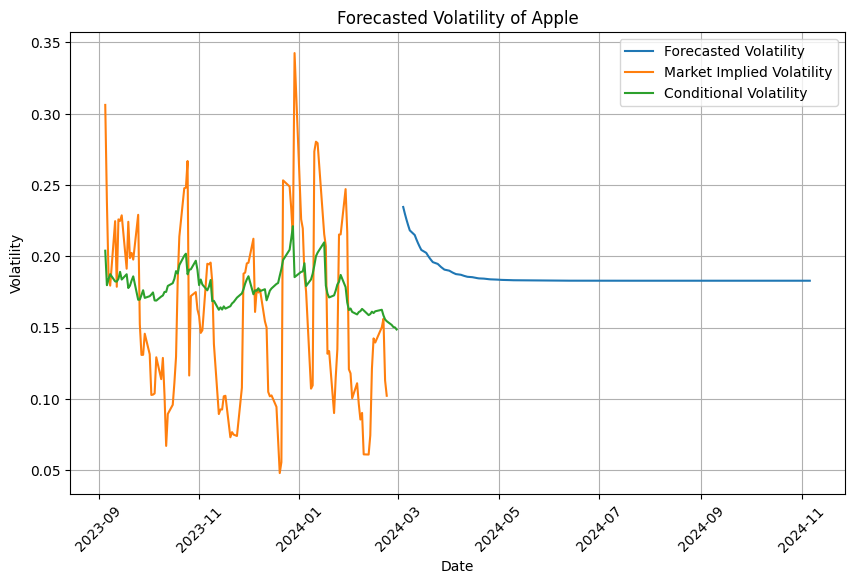

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['Date'], forecast_df['Forecasted Volatility'], label='Forecasted Volatility')
plt.plot(df.RollingVol, label='Market Implied Volatility')
plt.plot(df['Conditional Volatility'], label='Conditional Volatility')
plt.title('Forecasted Volatility of Apple')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()